# Cargue y preentrenamiento de datos

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas


In [3]:
# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Propio'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta


{'Basket': {(255, 255), (256, 256)},
 'Campo_Futbol': {(255, 255), (256, 256), (4080, 4080)},
 'Cancha_Multiple': {(255, 255), (256, 256), (4080, 4080)},
 'Parque': {(255, 255), (256, 256)},
 'Tenis': {(255, 255), (256, 256)}}

In [4]:
nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

C:\Users\nicol\AppData\Local\Temp\ipykernel_16864\279961940.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.


In [5]:
# Codificar las etiquetas
codificacion = {'Basket': 0, 'Campo_Futbol': 1, 'Cancha_Multiple': 2, 'Parque': 3, 'Tenis': 4}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))


Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 284, 1: 285, 2: 271, 3: 260, 4: 264}


In [6]:
# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))


Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 285, 1: 285, 2: 285, 3: 285, 4: 285}


In [7]:
# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))

Número de ejemplos de entrenamiento antes del balanceo: 1364
Número de ejemplos de entrenamiento después del balanceo: 1425
Número de ejemplos de prueba: 341


# Entrenamiento modelo customizado

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Crear un modelo secuencial
modelo = Sequential()

# Agregar una capa convolucional
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Agregar una capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar otra capa convolucional
modelo.add(Conv2D(64, (3, 3), activation='relu'))

# Agregar otra capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar una capa de aplanamiento
modelo.add(Flatten())

# Agregar una capa totalmente conectada
modelo.add(Dense(64, activation='relu'))

# Agregar la capa de salida
modelo.add(Dense(5, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()


c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,805 (60.14 MB)

 Trainable params: 15,764,805 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping para detener el entrenamiento si la métrica no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

In [12]:
# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Entrenar el modelo con los callbacks
historial_entrenamiento = modelo.fit(
    X_train_res, 
    y_train_res, 
    epochs=15, 
    validation_data=(X_train_res, y_train_res),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2615 - loss: 2.3180 - val_accuracy: 0.5011 - val_loss: 1.2439 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 983ms/step - accuracy: 0.5521 - loss: 1.1054 - val_accuracy: 0.6737 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 882ms/step - accuracy: 0.7233 - loss: 0.7580 - val_accuracy: 0.8589 - val_loss: 0.5219 - learning_rate: 0.0010
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 895ms/step - accuracy: 0.8625 - loss: 0.4761 - val_accuracy: 0.9347 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 886ms/step - accuracy: 0.9325 - loss: 0.2546 - val_accuracy: 0.9586 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 917ms/step - accuracy: 0.9699 - loss: 0.1081 - val_accuracy: 0.9986 - val_loss: 0.0291 - learning_rate: 9.0484e-04
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 833ms/step - accuracy: 0.9973 - loss: 0

In [13]:
resultados_evaluacion = modelo.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.6433 - loss: 1.1969


In [14]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Basket', 'Campo_Futbol', 'Cancha_Multiple', 'Parque', 'Tenis']))

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Precision: 0.6560062497702657
Recall: 0.6510263929618768
F1 Score: 0.6468608642362308
Accuracy: 0.6510263929618768
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.44      0.53      0.48        74
   Campo_Futbol       0.86      0.83      0.85        84
Cancha_Multiple       0.56      0.33      0.42        57
         Parque       0.74      0.74      0.74        68
          Tenis       0.63      0.76      0.69        58

       accuracy                           0.65       341
      macro avg       0.65      0.64      0.63       341
   weighted avg       0.66      0.65      0.65       341



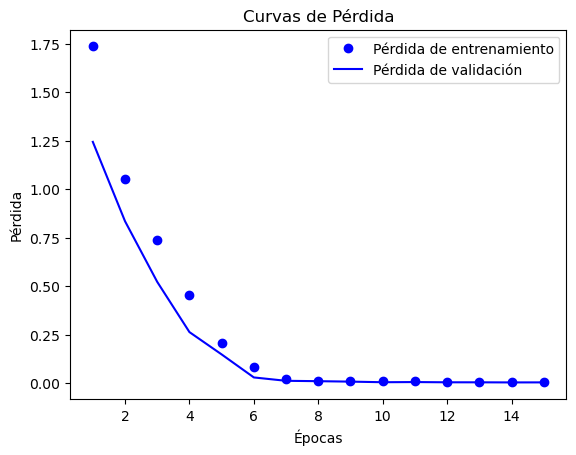

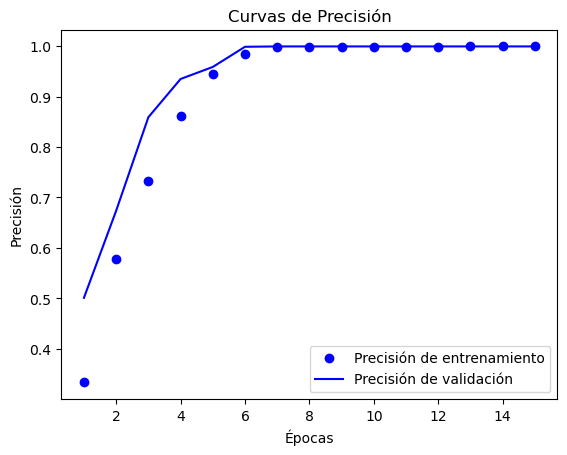

In [15]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del historial de entrenamiento
pérdida = historial_entrenamiento.history['loss']
precisión = historial_entrenamiento.history['accuracy']
val_pérdida = historial_entrenamiento.history['val_loss']
val_precisión = historial_entrenamiento.history['val_accuracy']

# Visualizar las curvas de pérdida y precisión
épocas = range(1, len(pérdida) + 1)
plt.plot(épocas, pérdida, 'bo', label='Pérdida de entrenamiento')
plt.plot(épocas, val_pérdida, 'b', label='Pérdida de validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(épocas, precisión, 'bo', label='Precisión de entrenamiento')
plt.plot(épocas, val_precisión, 'b', label='Precisión de validación')
plt.title('Curvas de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


# Entrenamiento con VGG16

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  



In [17]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.2934 - loss: 2.7099 - val_accuracy: 0.5191 - val_loss: 1.2613 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.4215 - loss: 1.2574 - val_accuracy: 0.6305 - val_loss: 1.0063 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.4601 - loss: 1.1396 - val_accuracy: 0.6100 - val_loss: 0.9884 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.5467 - loss: 0.9932 - val_accuracy: 0.7419 - val_loss: 0.8178 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.5859 - loss: 0.9357 - val_accuracy: 0.7126 - val_loss: 0.8041 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.6114 - loss: 0.8312 - val_accuracy: 0.7097 - val_loss: 0.8081 - learning_rate: 9.0484e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.6460 - loss: 0.7837 - val

In [18]:

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Basket', 'Campo_Futbol', 'Cancha_Multiple', 'Parque', 'Tenis']))

11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step
Precision: 0.7756716486422871
Recall: 0.7712609970674487
F1 Score: 0.7712113717764317
Accuracy: 0.7712609970674487
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.58      0.59      0.59        74
   Campo_Futbol       0.99      0.88      0.93        84
Cancha_Multiple       0.62      0.54      0.58        57
         Parque       0.92      0.96      0.94        68
          Tenis       0.71      0.84      0.77        58

       accuracy                           0.77       341
      macro avg       0.76      0.76      0.76       341
   weighted avg       0.78      0.77      0.77       341



# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.001
patience = 3  # Paciencia para EarlyStopping

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])


# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet-18 preentrenado
model = models.resnet18(pretrained=True)

# Congelar todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa para que coincida con el número de clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5) 

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping variables
best_loss = np.Inf
epochs_no_improve = 0
early_stop = False

c:\Users\nicol\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
    
    # Calcular la pérdida media
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


Epoch 1, Loss: 1.4297729465696547
Validation Loss: 1.1413363109935413
Epoch 2, Loss: 1.0903220309151544
Validation Loss: 0.9894820072434165
Epoch 3, Loss: 0.9351172751850552
Validation Loss: 0.8842610987749967
Epoch 4, Loss: 0.8600048899650574
Validation Loss: 0.8122402104464445
Epoch 5, Loss: 0.8049014250437418
Validation Loss: 0.7792271375656128
Epoch 6, Loss: 0.762787659962972
Validation Loss: 0.7610108039595864
Epoch 7, Loss: 0.7298314597871568
Validation Loss: 0.7144485224377025
Epoch 8, Loss: 0.6782502935992347
Validation Loss: 0.700478960167278
Epoch 9, Loss: 0.6644371098942227
Validation Loss: 0.6768219877373088
Epoch 10, Loss: 0.6402477496200137
Validation Loss: 0.6635413847186349


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')



Accuracy: 79.17889%
Precision: 0.79240
Recall: 0.79179
F1 Score: 0.79120


# Modelo Preentrenado Xception con ImageNet

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  




In [21]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.3675 - loss: 8.5033 - val_accuracy: 0.5161 - val_loss: 1.1080 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.4875 - loss: 1.1499 - val_accuracy: 0.6393 - val_loss: 0.8372 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.5839 - loss: 0.9552 - val_accuracy: 0.6833 - val_loss: 0.7897 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.6204 - loss: 0.8265 - val_accuracy: 0.6657 - val_loss: 0.8066 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.6671 - loss: 0.8276 - val_accuracy: 0.7185 - val_loss: 0.6787 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.7053 - loss: 0.6580 - val_accuracy: 0.7243 - val_loss: 0.7364 - learning_rate: 9.0484e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.7229 - loss: 0.7075 - val

In [22]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Basket', 'Campo_Futbol', 'Cancha_Multiple', 'Parque', 'Tenis']))

11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step
Precision: 0.8261583676992222
Recall: 0.8035190615835777
F1 Score: 0.8081798628672745
Accuracy: 0.8035190615835777
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.61      0.85      0.71        74
   Campo_Futbol       0.95      0.86      0.90        84
Cancha_Multiple       0.69      0.60      0.64        57
         Parque       0.97      0.82      0.89        68
          Tenis       0.89      0.84      0.87        58

       accuracy                           0.80       341
      macro avg       0.82      0.79      0.80       341
   weighted avg       0.83      0.80      0.81       341



In [23]:
from tensorflow.keras.models import load_model

# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/PropioCopy_Xception.h5')

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.01

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [37]:
# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (6 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)

model = model.to(device)

In [38]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping variables
best_loss = np.Inf
epochs_no_improve = 0
early_stop = False

In [39]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
    
    # Calcular la pérdida media
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


Epoch 1, Loss: 2.1254162814882065
Validation Loss: 11.323836499994451
Epoch 2, Loss: 1.4485477368036905
Validation Loss: 1.3214464295994153
Epoch 3, Loss: 1.285285602675544
Validation Loss: 1.219642693346197
Epoch 4, Loss: 1.2163973053296406
Validation Loss: 2.327331467108293
Epoch 5, Loss: 1.1259069098366632
Validation Loss: 1.349635194648396
Epoch 6, Loss: 1.044182476732466
Validation Loss: 1.4087301059202715
Early stopping triggered


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

Accuracy: 48.09384%
Precision: 0.56624
Recall: 0.48094
F1 Score: 0.45996


# Otros

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15
batch_size = 32
learning_rate = 0.001

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)

model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Definir el scheduler para reducir la tasa de aprendizaje
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
    
    # Ajustar la tasa de aprendizaje
    scheduler.step(running_loss / len(trainloader))
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Evaluación del modelo
model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [42]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/PropioCopy_mobileNET.pth')

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15
batch_size = 32
learning_rate = 0.001

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Cargar el modelo MobileNet preentrenado
model = models.resnet18(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases
model.fc = nn.Linear(model.fc.in_features, 5)

model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Definir el scheduler para reducir la tasa de aprendizaje
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
    
    # Ajustar la tasa de aprendizaje
    scheduler.step(running_loss / len(trainloader))
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Evaluación del modelo
model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/PropioCopy_Resnet18.pth')

Epoch 1, Loss: 1.0683564835124546
Epoch 2, Loss: 0.516846874025133
Epoch 3, Loss: 0.2910675976011488
Epoch 4, Loss: 0.27204339421457713
Epoch 5, Loss: 0.1832970770696799
Epoch 6, Loss: 0.16047468206120863
Epoch 7, Loss: 0.1485070678508944
Epoch 8, Loss: 0.08297805174046921
Epoch 9, Loss: 0.04863308243867424
Epoch 10, Loss: 0.1457754095809327
Epoch 11, Loss: 0.07167434272252851
Epoch 12, Loss: 0.03701796089816425
Epoch 13, Loss: 0.028362411774125778
Epoch 14, Loss: 0.05954135700077232
Epoch 15, Loss: 0.0852043794778486
Accuracy: 88.56305%
Precision: 0.88980
Recall: 0.88563
F1 Score: 0.88676


In [16]:
import torch
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Asegúrate de que el modelo esté en modo de evaluación
model.eval()

# Si `X_test` es una lista de imágenes, conviértelo en un tensor y transfiérelo a la GPU si es necesario
imagenes_tensor = torch.tensor(X_test).permute(0, 3, 1, 2).type(torch.float32).to(device)

# Desactivar el cálculo de gradientes para la evaluación
with torch.no_grad():
    y_pred_prob = model(imagenes_tensor)
    y_pred = torch.argmax(y_pred_prob, dim=1).cpu().numpy()  # Convertir las predicciones a numpy array

# `y_test` debe estar en la CPU como un numpy array
y_test = y_test.cpu().numpy() if torch.is_tensor(y_test) else y_test


In [17]:
# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Basket', 'Campo_Futbol', 'Cancha_Multiple', 'Parque', 'Tenis']))


Precision: 0.44899953371610124
Recall: 0.4604105571847507
F1 Score: 0.3863449617632231
Accuracy: 0.4604105571847507
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.30      0.84      0.44        74
   Campo_Futbol       0.66      0.71      0.69        84
Cancha_Multiple       0.50      0.02      0.03        57
         Parque       0.00      0.00      0.00        68
          Tenis       0.81      0.59      0.68        58

       accuracy                           0.46       341
      macro avg       0.45      0.43      0.37       341
   weighted avg       0.45      0.46      0.39       341



c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\anaconda3\lib\site-packag